In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

2023-03-14 12:00:03.159851: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 12:00:03.191602: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
dataset = np.load('/home/faster/Documents/wind_prediction/10m_u-component_of_wind_2022_hourly.npz')['arr_0']

In [3]:
dataset.shape

(730, 12, 201, 201)

In [4]:
dataset = dataset[:,:,64:128,64:128]

In [5]:
dataset.shape

(730, 12, 64, 64)

In [6]:
#add channel
dataset = np.expand_dims(dataset, axis=-1)

In [7]:
#dataset normalization
dataset = (dataset - dataset.min(axis=0)) / (dataset.max(axis=0) - dataset.min(axis=0))

In [8]:
#mean = np.mean(dataset, axis = 0)
#std = np.std(dataset, axis = 0)
#dataset = (dataset - mean)/std
#dataset = (dataset - dataset.mean(axis=0) / dataset.std(axis=0))

In [9]:
dataset = dataset[:700]

In [10]:

#indexes = np.arange(dataset.shape[0])
#np.random.shuffle(indexes)
#train_index = indexes[: int(0.9 * dataset.shape[0])]
#val_index = indexes[int(0.9 * dataset.shape[0]) :]
#train_dataset = dataset[train_index]
#val_dataset = dataset[val_index]
train_dataset = dataset[:600]
val_dataset = dataset[600:]

In [11]:
lenght = 10
# We'll define a helper function to shift the frames, where
# `x` is frames 0 to n - 1, and `y` is frames 1 to n.
def create_shifted_frames_mod(data):
    ran = np.random.randint(0,12-lenght-1)
    x = data[:, ran  : ran + lenght, :, :]
    y = data[:, ran + 1 : ran + lenght + 1, :, :]
    return x, y

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


# Apply the processing function to the datasets.
x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)

# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (600, 11, 64, 64, 1), (600, 11, 64, 64, 1)
Validation Dataset Shapes: (100, 11, 64, 64, 1), (100, 11, 64, 64, 1)


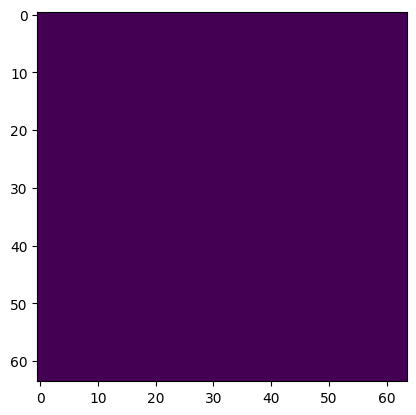

In [12]:
plt.imshow(x_train[1,1]-y_train[1,0])

In [13]:

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
from datetime import datetime
imagesx = []
imagesy = []
for i in range(11):
    imagesx.append((np.squeeze(x_train[data_choice][i]) * 255).astype('uint8'))
    imagesy.append((np.squeeze(x_train[data_choice][i]) * 255).astype('uint8'))

imageio.mimsave(str(datetime.now())+'randx.gif', imagesx,fps=2)
imageio.mimsave(str(datetime.now())+'randy.gif', imagesy,fps=2)

In [14]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

2023-03-14 12:00:10.120830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 12:00:10.133397: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 12:00:10.133936: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 12:00:10.134696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

In [11]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.Normalization()(inp)

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="tanh",
)(x)
x = layers.BatchNormalization()(x)

x = layers.ConvLSTM2D(
    filters=1,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="sigmoid",
)(x)


# Next, we will build the complete model and compile it.
model = keras.models.Model(inp, x)
model.compile(
    loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam(),
)

2023-03-14 11:25:19.138622: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:25:19.150696: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:25:19.151243: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-14 11:25:19.152063: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 64, 64, 1)  0         
                             ]                                   
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, None, 64, 64, 128  1651712   
                             )                                   
                                                                 
 batch_normalization (BatchN  (None, None, 64, 64, 128  512      
 ormalization)               )                                   
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, None, 64, 64, 128  1180160   
                             )                                   
                                                                 
 batch_normalization_1 (Batc  (None, None, 64, 64, 128  512  

In [16]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10


2023-03-14 12:00:17.094579: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2023-03-14 12:00:17.690223: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 12:00:17.690700: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 12:00:17.690715: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-14 12:00:17.691069: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-14 12:00:17.691104: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-03-14 12:00:17.828238: I tensorflow/stream_executor/cuda/c

120/120 [==============================] - 46s 360ms/step - loss: 0.6495 - val_loss: 0.6823 - lr: 0.0010
Epoch 2/10
120/120 [==============================] - 44s 364ms/step - loss: 0.6316 - val_loss: 0.6684 - lr: 0.0010
Epoch 3/10
120/120 [==============================] - 44s 366ms/step - loss: 0.6299 - val_loss: 0.6516 - lr: 0.0010
Epoch 4/10
120/120 [==============================] - 45s 372ms/step - loss: 0.6291 - val_loss: 0.6341 - lr: 0.0010
Epoch 5/10
120/120 [==============================] - 44s 366ms/step - loss: 0.6279 - val_loss: 0.6332 - lr: 0.0010
Epoch 6/10
120/120 [==============================] - 44s 366ms/step - loss: 0.6270 - val_loss: 0.6233 - lr: 0.0010
Epoch 7/10
120/120 [==============================] - 44s 367ms/step - loss: 0.6269 - val_loss: 0.6214 - lr: 0.0010
Epoch 8/10
120/120 [==============================] - 45s 373ms/step - loss: 0.6266 - val_loss: 0.6227 - lr: 0.0010
Epoch 9/10
120/120 [==============================] - 45s 373ms/step - loss: 0.6267

In [29]:
#model.load_weights('wind.h5')

1/1 [==============================] - 0s 41ms/step


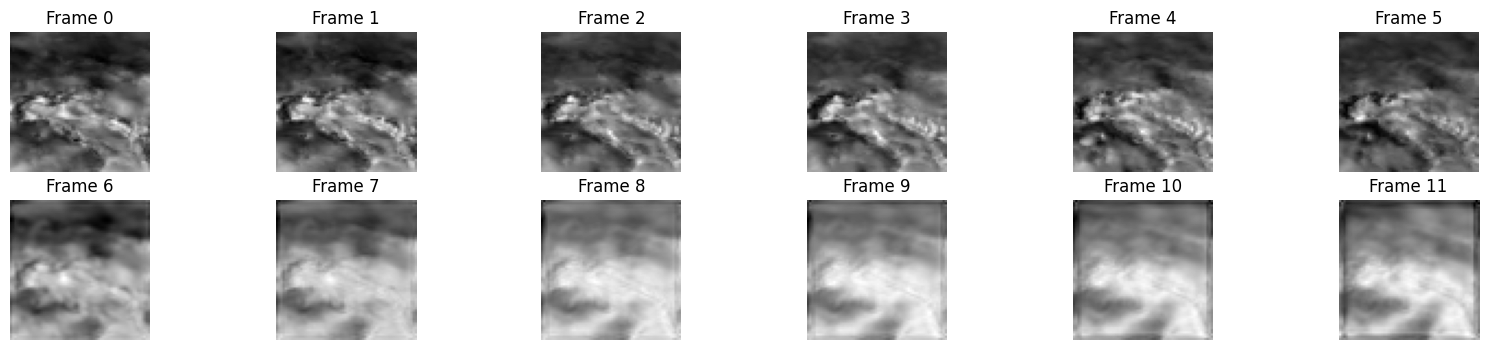

In [61]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:6, ...]
original_frames = example[6:, ...]

# Predict a new set of 10 frames.
for _ in range(6):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 6, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[6:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 6}")
    ax.axis("off")

# Display the figure.
plt.show()

1/1 [==============================] - 0s 50ms/step
(1, 12, 64, 64, 1)
1/1 [==============================] - 0s 53ms/step
(1, 13, 64, 64, 1)
1/1 [==============================] - 0s 54ms/step
(1, 14, 64, 64, 1)
1/1 [==============================] - 0s 58ms/step
(1, 15, 64, 64, 1)
1/1 [==============================] - 0s 57ms/step
(1, 16, 64, 64, 1)
1/1 [==============================] - 0s 59ms/step
(1, 17, 64, 64, 1)
1/1 [==============================] - 0s 63ms/step
(1, 18, 64, 64, 1)
1/1 [==============================] - 0s 66ms/step
(1, 19, 64, 64, 1)
1/1 [==============================] - 0s 70ms/step
(1, 20, 64, 64, 1)
1/1 [==============================] - 0s 66ms/step
(1, 21, 64, 64, 1)
1/1 [==============================] - 0s 69ms/step
(1, 22, 64, 64, 1)
1/1 [==============================] - 0s 74ms/step
(1, 23, 64, 64, 1)
1/1 [==============================] - 0s 76ms/step
(1, 24, 64, 64, 1)
1/1 [==============================] - 0s 80ms/step
(1, 25, 64, 64, 1)
1/1 [=

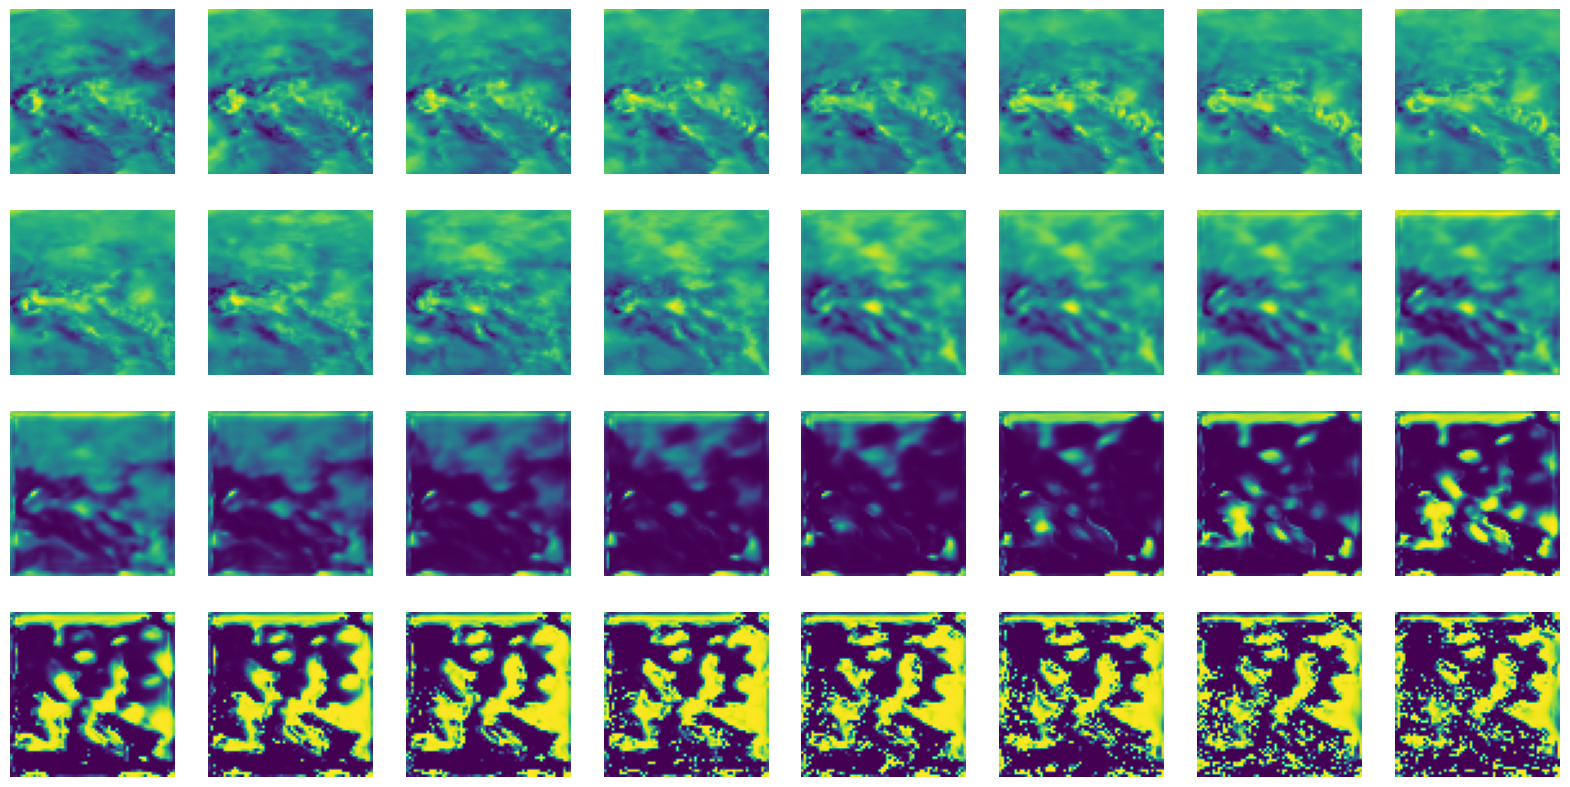

In [62]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:12, ...]

# Predict a new set of 10 frames.
for _ in range(20):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    print(new_prediction.shape)
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for i in range(8):
  axes[0,i].imshow(frames[i])
  axes[0,i].axis("off")
  axes[1,i].imshow(frames[i+8])
  axes[1,i].axis("off")
  axes[2,i].imshow(frames[i+16])
  axes[2,i].axis("off")
  axes[3,i].imshow(frames[i+24])
  axes[3,i].axis("off")

# Display the figure.
plt.show()

In [63]:
from datetime import datetime
images = []
for i in range(frames.shape[0]):
    images.append((np.squeeze(frames[i]) * 255).astype('uint8'))

imageio.mimsave(str(datetime.now())+'fullpred.gif', images,fps=2)

In [20]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:6, ...]
    original_frames = example[6:, ...]
    new_predictions = np.zeros(shape=(6, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(6):
        # Extract the model's prediction and post-process it.
        frames = example[: 6 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame
        
new_pred_gif = []    
orig_gif = []
for i in range(new_predictions.shape[0]):
    new_pred_gif.append((np.squeeze(new_predictions[i]) * 255).astype('uint8'))
    orig_gif.append((np.squeeze(original_frames[i]) * 255).astype('uint8'))

imageio.mimsave(str(datetime.now())+'pred.gif', new_pred_gif,fps=2)
imageio.mimsave(str(datetime.now())+'orig.gif', orig_gif,fps=2)

1/1 [==============================] - 0s 12ms/step


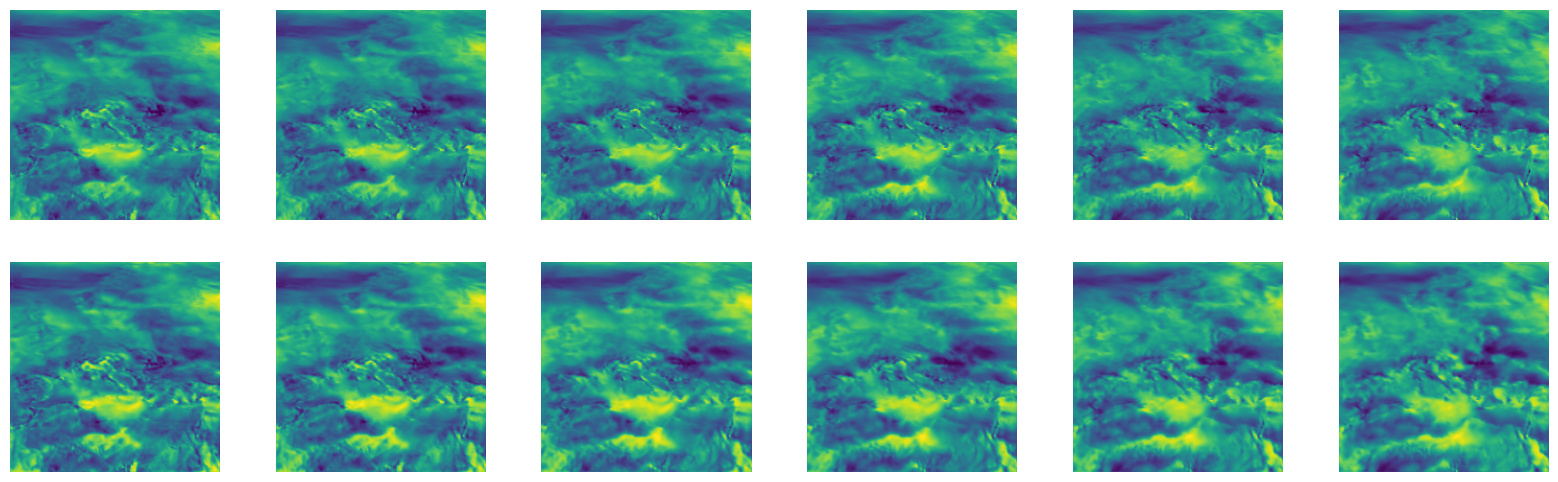

In [21]:
# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 6, figsize=(20, 6))

for i in range(6):
  axes[0,i].imshow(original_frames[i])
  axes[0,i].axis("off")
  axes[1,i].imshow(new_predictions[i])
  axes[1,i].axis("off")


# Display the figure.
plt.show()